Notebook for cleaning (real-world) graphs from unrelated roads and apartment areas.

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
# from imposm.parser import OSMParser
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sbn
import math
from tqdm import *
import re
import json
from shapely.geometry import MultiPolygon, Polygon, Point

In [96]:
amenities = "amenity::(fast_food|bar|bbq|biergarten|cafe|food_court|ice_cream|pub|restaurant)"

In [97]:
def get_hours(tags):
    m = re.search("opening_hours::[A-z- ]*(\d+):(\d+)-(\d+):(\d+)",tags)
    m2 = re.search(amenities,tags)
    if m and m2:
        return int(float(m.group(3)) + float(m.group(4))/60. - float(m.group(1)) - float(m.group(2))/60.)
    else:
        return -1

In [98]:
get_hours("amenity::cafe;;cuisine::burger;;fvst:navnelbnr::23879;;name::Café Stygge;;opening_hours::10:30-22:00; Su off;;phone::+45 98142214;;website::http://cafestygge.dk/;;")

11

In [103]:
G = nx.Graph()
node_lat = {}
node_lon = {}
node_tags = {}
graph_id = 0
# fname = '../data/copenhagen_center.ntw'
# fname = '../data/cph_center_bigger.ntw'
# fname = '../data/cph_center_sq.ntw' #delta 55.666 12.5617
storage_path = '/q/storage/alogins/fcla_data/real/cph_multicap/'
# fname = storage_path + 'cph_center_sq.ntw'
fname = storage_path + 'cph_full.ntw'
with open(fname,'r') as f:
    t = f.readline().split()
    graph_id = int(t[0])
    print(t[0])
    nodes = int(t[1])
    edges = int(t[2])
    for i in range(edges):
        info = f.readline().split()
        id1 = int(info[0])
        id2 = int(info[1])
        assert(id1 < nodes)
        assert(id2 < nodes)
        G.add_edge(id1, id2, weight=info[2], etype=info[3])
    for i in range(nodes):
        info = f.readline().split()
        try:
            node_lat[i] = info[0]
            node_lon[i] = info[1]
            if (len(info) > 2):
                node_tags[i] = get_hours(info[2])
            else:
                node_tags[i] = -1
            if i not in G:
                G.add_node(i)
        except IndexError:
            print(info)
nx.set_node_attributes(G, 'lat', node_lat)
nx.set_node_attributes(G, 'lon', node_lon)

1507707731459521388


In [104]:
# build tree for points and find NN for each shop with working hours
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy import spatial

#nodes of a graph
shop_points = []
shop_points_tags = []

i = 0
for node in G.nodes_iter():
    if node_tags[i] > -1:
        shop_points.append((float(G.node[node]['lat']), float(G.node[node]['lon'])))
        shop_points_tags.append(node_tags[i])
    i += 1

In [67]:
to_delete = []
for edge in nx.edges_iter(G):
    if G[edge[0]][edge[1]]["etype"] in ["unrelated",'cycleway','pedestrian','footway','steps','path','railway']:
        to_delete.append(edge)
for e in to_delete:
    G.remove_edge(e[0],e[1])
    
to_delete = []
for node in nx.nodes_iter(G):
    if G.degree(node) < 1:
        to_delete.append(node)
for n in to_delete:
    G.remove_node(n)

In [68]:
len(G)

31613

In [69]:
graphs = list(nx.connected_component_subgraphs(G))
print("total components", len(list(graphs)))
for g in graphs:
    if len(g) > 1000:
        print("biggest component",len(g))

total components 1306
biggest component 9468


In [70]:
for g in graphs:
    if len(g) > 1000:
        print(len(g))
        G = nx.convert_node_labels_to_integers(g)
        break

9468


In [71]:
len(list(nx.connected_component_subgraphs(G)))

1

In [72]:
# map shops
graph_points = []
for node in G.nodes_iter():
    graph_points.append((float(G.node[node]['lat']), float(G.node[node]['lon'])))
    
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(graph_points)
distances, indices = nbrs.kneighbors(shop_points)

hour_attr = {}
for i in range(len(shop_points)):
    hour_attr[indices[i][0]] = shop_points_tags[i]

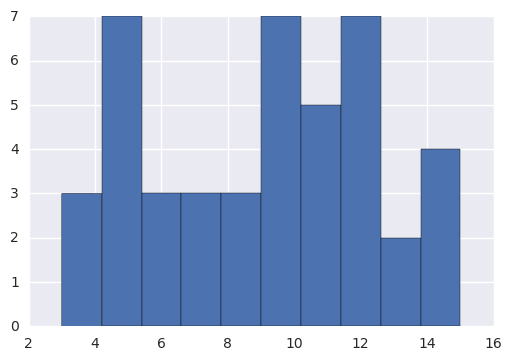

In [73]:
pd.Series(hour_attr).hist()

## Export with random customers

In [87]:
def export_graph(path, graph_id, sources):
    '''
    Sources is a vector with ids of source nodes
    '''
    new_node_map = {}
    i = 0
    for n in G.nodes(data=True):
        new_node_map[n[0]] = i
        i += 1

    with open(path + str(graph_id) + ".ntw",'w') as f:
        f.write("%d %d %d %d\n" % (graph_id, len(G), nx.number_of_edges(G), len(sources))) 
        for e in G.edges(data=True):
            f.write("%d %d %s\n" % (new_node_map[e[0]], new_node_map[e[1]], e[2]['weight']))
        for i in sources:
            f.write("%d\n" % i)
        i = 0
        for n in G.nodes(data=True):
            assert(new_node_map[n[0]] == i)
            i += 1
            f.write("%s %s\n" % (n[1]['lat'], n[1]['lon']))

In [15]:
#export with certain number of customers and readible format - create for multiple source count (many files)
# new_node_map = {}
# i = 0
# for n in G.nodes(data=True):
#     new_node_map[n[0]] = i
#     i += 1

# for sources in tqdm([2**x for x in range(7,17)]):  
#     export_graph('../data/aalborg/modified/', graph_id+1, sources)

100%|██████████| 10/10 [00:00<00:00, 24.23it/s]


In [79]:
# save potential facility locations in a separate file, one file per one city

#first number is resulting average bandwith of a cafe per day, i.e. # of customers one facility can serve
capacity_scale = 1
df = pd.Series(capacity_scale*pd.Series(hour_attr),dtype=int)
df.to_csv("facility_location_hours.csv",sep=" ")
df.mean(), len(df), df.mean() * len(df)

(9.0909090909090917, 44, 400.00000000000006)

## Export with population-based customers and potential facilities

In [80]:
def transform_point(point):
    lat = point[1]
    lon = point[0]
    lat0 = 55.677
    lon0 = 12.5767
    dlat = lat - lat0;
    dlon = lon - lon0;
    latitudeCircumference = 40075160. * math.cos(lat0 * math.pi/180.0);
    resX = dlon * latitudeCircumference / 360. ;
    resY = dlat * 40008000. / 360. ;
    return [resX, resY]

def transform_coords(polygon):
    new_polygon = []
    for point in polygon:
        new_polygon.append(transform_point(point))
    return new_polygon

In [81]:
# load geojson with regions
f = open(storage_path + "cph-regions.geojson","r")
data = json.loads(f.read())


regions = {}
for j in range(len(data['features'])):
#     print transform_coords(data['features'][j]['geometry']['coordinates'][i][0])
#     break
    m = MultiPolygon([Polygon(transform_coords(data['features'][j]['geometry']['coordinates'][i][0]))
                      for i in range(len(data['features'][j]['geometry']['coordinates']))])
    regions[int(data['features'][j]['properties']['rode_nr'])] = m

regions

{1: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaae80>,
 2: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaad30>,
 3: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaa9e8>,
 4: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaa240>,
 5: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaa2e8>,
 6: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaaa20>,
 7: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaa978>,
 8: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaa9b0>,
 9: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaa860>,
 10: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaaf28>,
 11: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaae48>,
 12: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaacc0>,
 13: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaadd8>,
 14: <shapely.geometry.multipolygon.MultiPolygon at 0x7ff58cbaae10>,
 15: <shapely.geometry.multipolygon.MultiPo

In [25]:
# map population of the latest year to each of regions
population = pd.read_csv(storage_path + "cph-population.csv")
population = population[population["AAR"] == population["AAR"].max()]

In [26]:
population.head()

,AAR,RODE,KOEN,ALDER,PERSONER
0,2015,1,1,0,6
1,2015,1,1,1,6
2,2015,1,1,3,3
3,2015,1,1,4,4
4,2015,1,1,5,3


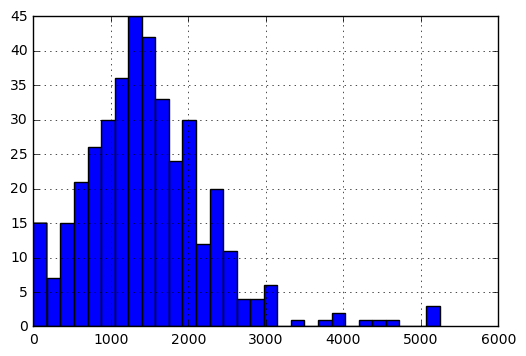

In [27]:
pop_map = population[['RODE','PERSONER']].groupby("RODE",as_index=False).sum()
pop_map['PERSONER'].hist(bins=30)

In [28]:
pop_map.head()

,RODE,PERSONER
0,1,549
1,2,698
2,3,385
3,4,295
4,5,251


In [43]:
# assign each graph node a corresponding distrinct (region)
def get_region_id(lat, lon):
    p = Point(lat, lon)
    for k in regions:
        if (regions[k].contains(p)):
            return k
    return -1

node_region_id = {}
region_node_list = {}
for node in tqdm(nx.nodes_iter(G)):
    reg_id = get_region_id(float(G.node[node]["lat"]), float(G.node[node]["lon"]))
#     if (reg_id == -1):
#         print "no"
#         break
    node_region_id[node] = reg_id
    if reg_id not in region_node_list:
        region_node_list[reg_id] = []
    region_node_list[reg_id].append(node)


0it [00:00, ?it/s]
38it [00:00, 377.42it/s]
71it [00:00, 361.05it/s]
132it [00:00, 408.85it/s]
197it [00:00, 456.82it/s]
295it [00:00, 542.95it/s]
386it [00:00, 617.30it/s]
456it [00:00, 632.39it/s]
524it [00:00, 571.42it/s]
597it [00:00, 606.19it/s]
693it [00:01, 675.52it/s]
783it [00:01, 729.79it/s]
887it [00:01, 786.80it/s]
971it [00:01, 637.11it/s]
1043it [00:01, 581.75it/s]
1112it [00:01, 610.26it/s]
1210it [00:01, 680.44it/s]
1284it [00:01, 653.38it/s]
1416it [00:02, 769.45it/s]
1551it [00:02, 880.19it/s]
1653it [00:02, 891.83it/s]
1752it [00:02, 867.61it/s]
1881it [00:02, 955.50it/s]
1985it [00:02, 693.74it/s]
2098it [00:02, 784.57it/s]
2234it [00:02, 891.21it/s]
2339it [00:03, 894.45it/s]
2440it [00:03, 870.41it/s]
2557it [00:03, 942.68it/s]
2659it [00:03, 845.48it/s]
2783it [00:03, 933.26it/s]
2891it [00:03, 971.99it/s]
2994it [00:03, 973.65it/s]
3096it [00:03, 852.89it/s]
3187it [00:04, 544.22it/s]
3260it [00:04, 545.44it/s]
3370it [00:04, 642.07it/s]
3471it [00:04, 720.30it

In [82]:
pd.Series(node_region_id).value_counts()

-1      2270
 65     1075
 36      728
 59      618
 62      539
 43      440
 63      405
 20      395
 18      266
 24      228
 30      187
 19      182
 45      175
 34      173
 25      165
 396     158
 15      152
 31      151
 21      142
 35      137
 12      126
 33       87
 29       63
 395      63
 61       59
 9        59
 37       56
 28       53
 11       52
 10       50
 64       47
 26       32
 22       32
 44       29
 16       18
 27       15
 32       12
 23        8
 56        7
 14        6
 60        5
 7         2
 17        1
dtype: int64

In [47]:
facility_fraction_in_region = {}
for region_id in regions:
    if (region_id in region_node_list) and (len(pop_map[pop_map["RODE"] == region_id]) > 0):
        facility_fraction_in_region[region_id] = \
            float(pop_map[pop_map["RODE"] == region_id]["PERSONER"]) #/ len(region_node_list[region_id])

#normalize region choice
regsum = np.sum(np.array([facility_fraction_in_region[k] for k in facility_fraction_in_region]))
facility_fraction_in_region_norm = {k: float(facility_fraction_in_region[k])/regsum 
                                    for k in facility_fraction_in_region}

probability_vector = [0]*len(G)
for region_id in regions:
    if region_id in facility_fraction_in_region:
        for node in region_node_list[region_id]:
            probability_vector[node] = facility_fraction_in_region_norm[region_id] * 1./len(region_node_list[region_id])
print(np.sum(np.array(probability_vector)))
# probability_vector = np.array(probability_vector)
# probability_vector = probability_vector/np.sum(probability_vector)

1.0


In [136]:
# save graph with customers
for number_of_customers in {10}:
    customer_node_ids = np.random.choice(len(probability_vector), 
                                         number_of_customers, 
                                         p=probability_vector, 
                                         replace=False)
    export_graph("./", graph_id+1, customer_node_ids)

In [92]:
number_of_customers = 40
customer_node_ids = np.random.choice(len(probability_vector), 
                                         number_of_customers, 
                                         p=probability_vector, 
                                         replace=False)

In [94]:
export_graph("./", graph_id+1, customer_node_ids)

In [ ]:
# probability vector is a probability of picking from a particular region

# Plotting

In [266]:
# plot results : plot map with regions, density and random customer assignment


# plots : all city of copenhagen; road map of copenhagen (using construction hierarchies); people density; 
# facility scatter; center with facilities and customers scattered randomly;

In [11]:
import geopandas as gp
glaciers = gp.GeoDataFrame.from_file('../data/cph-regions.geojson')
f = open("../data/cph-regions.geojson","r")
data = json.loads(f.read())
for j in range(len(data['features'])):
    for i in range(len(data['features'][j]['geometry']['coordinates'])):
        data['features'][j]['geometry']['coordinates'][i][0] = transform_coords(data['features'][j]['geometry']['coordinates'][i][0])
with open("tmp.txt","w") as f:
    f.write(json.dumps(data))
glaciers = gp.GeoDataFrame.from_file("tmp.txt")
glaciers.head()

,bydel,rode_nr,areal_m2,distrikt_nr,rodenavn,id,geometry
0,Østerbro,99,,7,Bellmans,111,"(POLYGON ((-1137.63229181488 4238.00385120971,..."
1,Indre by,17,,1,Holmens,9,(POLYGON ((370.4934657375431 -28.7004139420659...
2,Valby,227,,22,Flaskekroens,255,(POLYGON ((-5412.165050265035 -3392.7878997698...
3,Indre by,2,,1,Bispegårdens,12,(POLYGON ((-655.6850471244161 173.375625876342...
4,Indre by,3,,1,Rådhusets,13,(POLYGON ((-518.3399199642896 -32.989684665054...


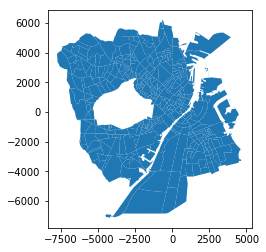

In [12]:
glaciers.plot()

In [79]:
glaciers["dens"] = glaciers["rode_nr"].apply(lambda rodeid: probability_vector[probability_index[rodeid]])
glaciers

,bydel,rode_nr,areal_m2,distrikt_nr,rodenavn,id,geometry,dens
0,Østerbro,99,,7,Bellmans,111,"(POLYGON ((-1137.63229181488 4238.00385120971,...",0.000000
1,Indre by,17,,1,Holmens,9,(POLYGON ((370.4934657375431 -28.7004139420659...,0.000000
2,Valby,227,,22,Flaskekroens,255,(POLYGON ((-5412.165050265035 -3392.7878997698...,0.000000
3,Indre by,2,,1,Bispegårdens,12,(POLYGON ((-655.6850471244161 173.375625876342...,0.000000
4,Indre by,3,,1,Rådhusets,13,(POLYGON ((-518.3399199642896 -32.989684665054...,0.000000
5,Indre by,6,,1,Synagogens,26,(POLYGON ((-325.9637067675721 657.489131958552...,0.000000
6,Indre by,7,,1,Reformert,27,(POLYGON ((-205.0026741435172 795.542333983413...,0.245911
7,Indre by,8,,1,Universitetets,28,(POLYGON ((-346.8118655158424 388.037237957343...,0.000000
8,Nørrebro,135,,8,Rantzaus,123,(POLYGON ((-1887.451730904132 1177.85402242083...,0.000000
9,Indre by,49,,1,Nyrops,16,(POLYGON ((-1348.867946082175 -369.98538898252...,0.000000


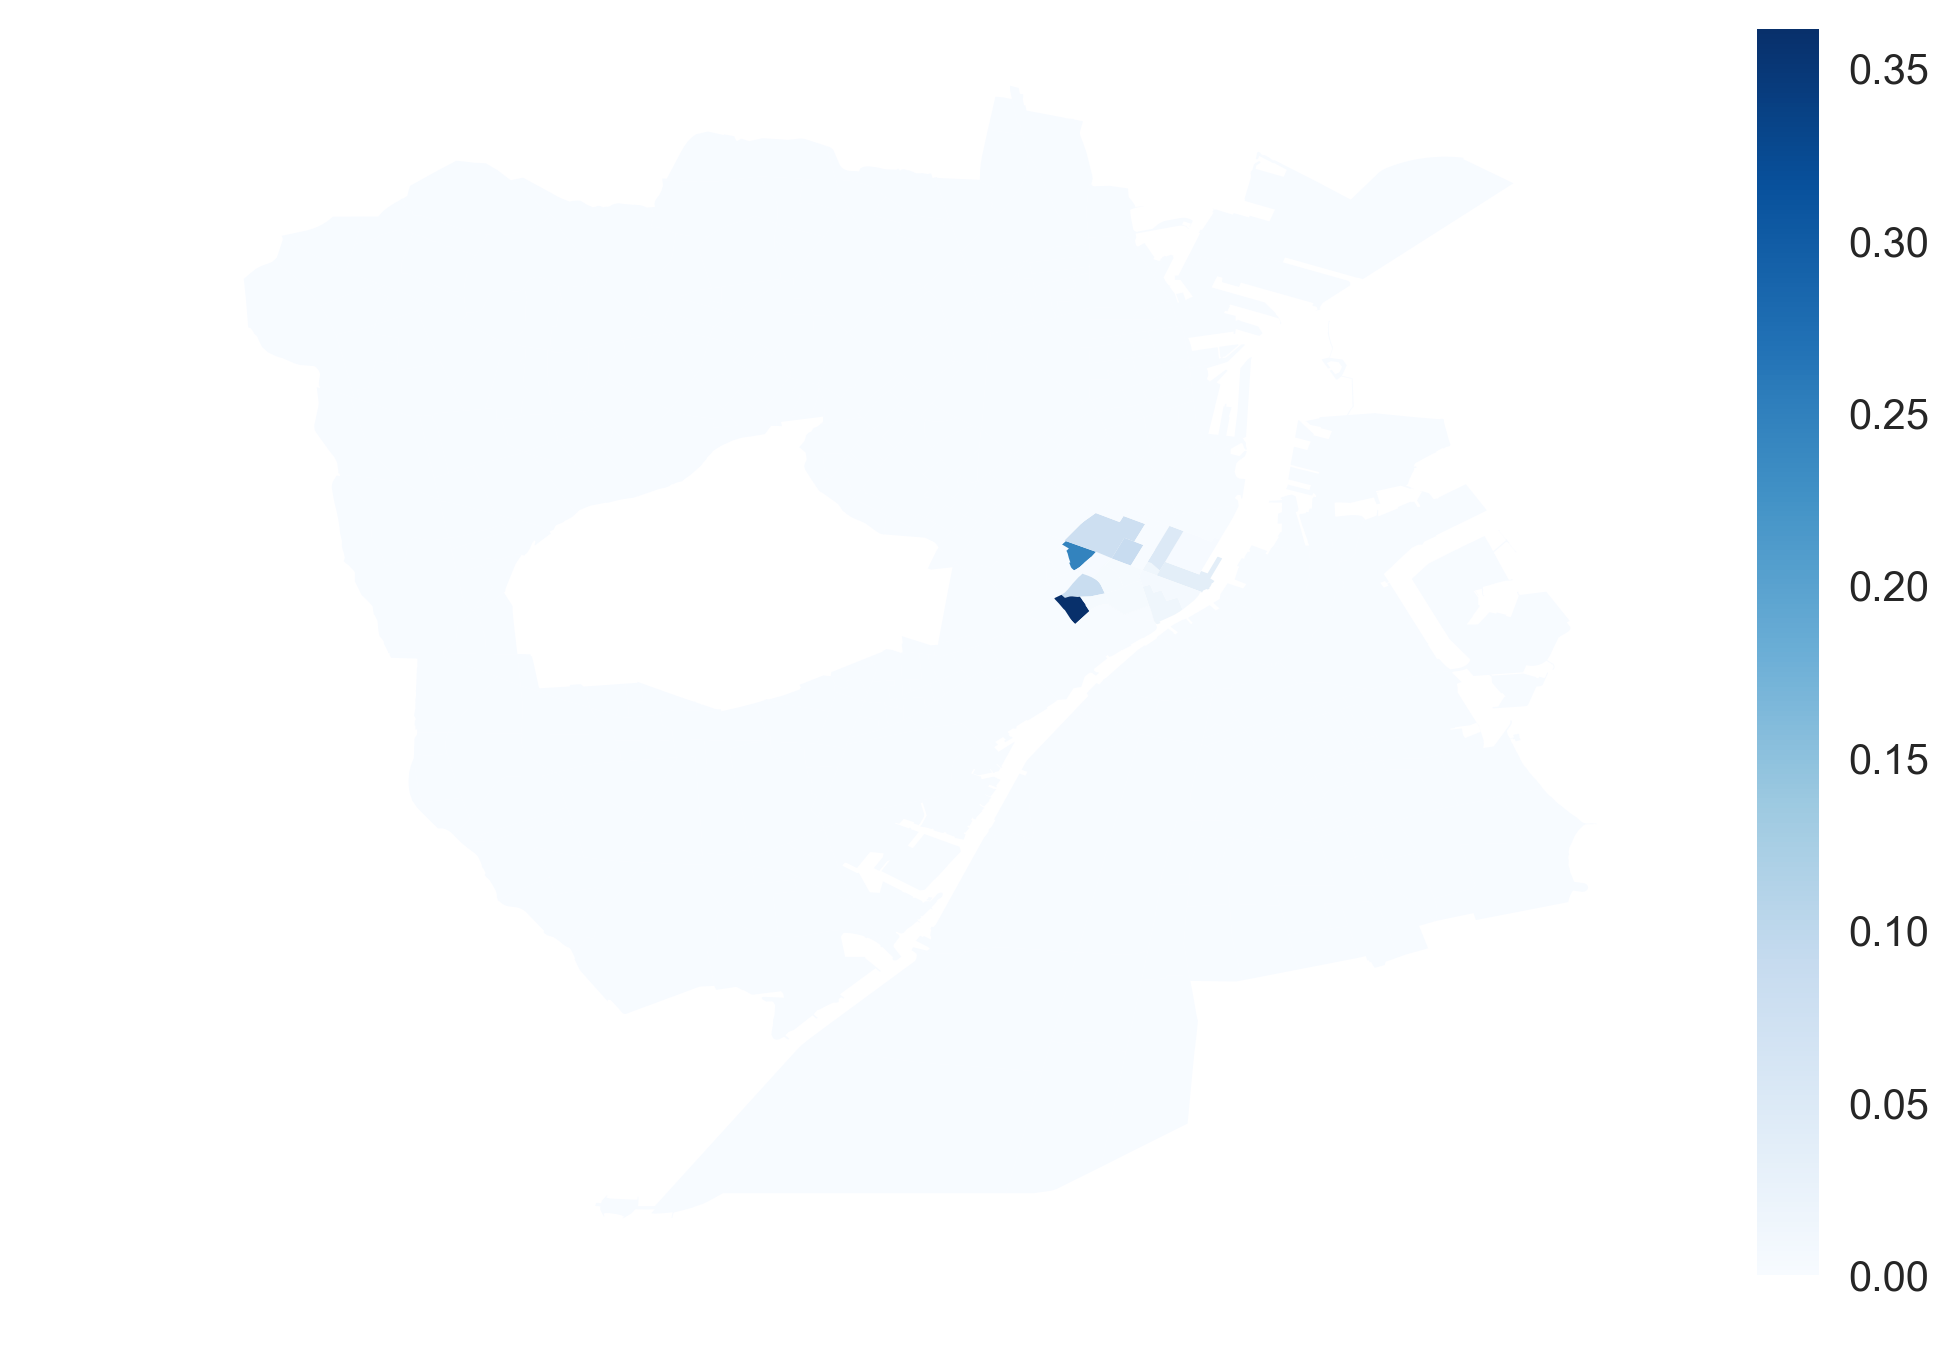

In [80]:
fig, ax1 = plt.subplots(1, dpi=300)
ax1.set_axis_off()
glaciers.plot(categorical=False,column="dens",colormap="Blues",ax=ax1, legend=True)

In [ ]:
# plot road network graph - http://geoffboeing.com/2016/11/osmnx-python-street-networks/

In [ ]:
# plot center network with assigned customers and facilities

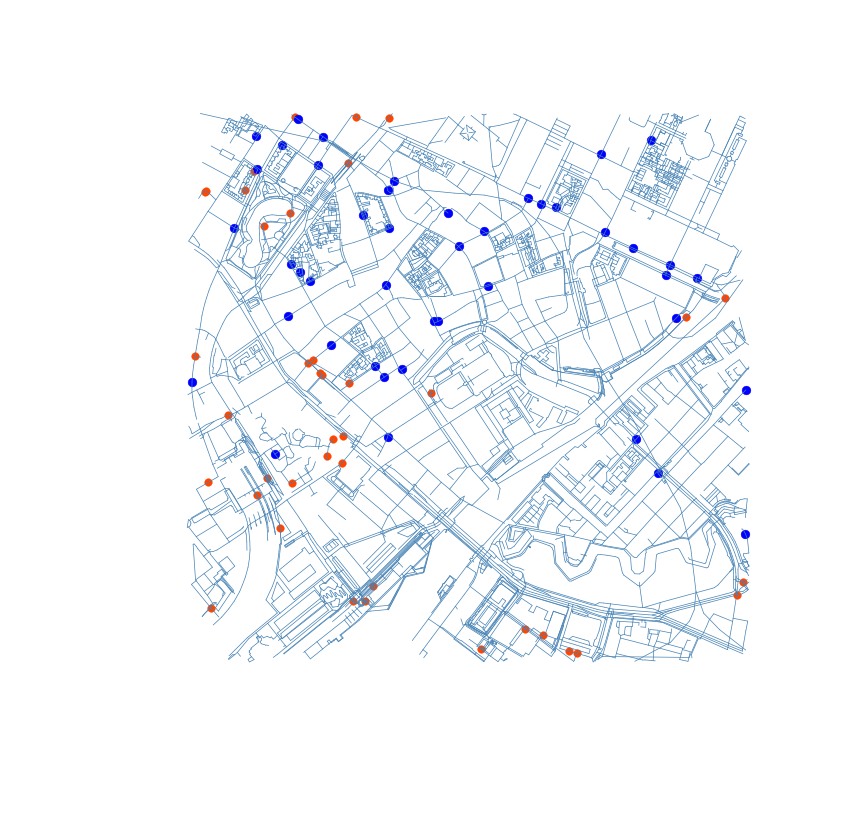

In [93]:
# print customers (shops)

#get customers
facility_coords = []
for key in hour_attr:
    facility_coords.append((G.node[key]['lat'], G.node[key]['lon']))

plt.figure(dpi=300,figsize=(10,10))
plt.axis('off')
        
for edge in nx.edges_iter(G):
    t = G[edge[0]][edge[1]]['etype'] 
#     plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
#              [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color=color_map[t],linewidth=0.5)
    plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
             [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color="steelblue",linewidth=0.5)

# tmp = []
# for node in nx.nodes_iter(G):
#     if len(G.node[node]) > 0:
#         tmp.append([G.node[node]['lat'],G.node[node]['lon']])
# tmp = np.array(tmp).T
# plt.scatter(tmp[0],tmp[1],marker='.',s=3)

tmp = []
for node in customer_node_ids:
    tmp.append([G.node[node]['lat'],G.node[node]['lon']])
tmp = np.array(tmp).T
plt.scatter(tmp[0],tmp[1],marker='o',color="orangered",s=30)
    

tmp = np.array(facility_coords).T
plt.scatter(tmp[0],tmp[1],marker='o',color="blue",s=40)